Random Forest를 활용한 2006년 ~ 2017년의 미국 주식 거래량 TOP 20 주식 가격 예측

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings(action='ignore')

## 데이터 불러오기

In [2]:
arqs = os.listdir("./data/") # data 폴더에 있는 파일명 불러오기
data=pd.DataFrame(pd.read_csv("./data/"+arqs[0])['Date']) # 일자 column을 포함한 데이터 프레임 만들기
for a in arqs: # 위에서 지정한 경로의 각각의 파일에 대해
    name=a.replace('_2006-01-01_to_2018-01-01.csv','') # 파일명에서 일자를 삭제하고 주식 이름만 남기기
    arq = pd.DataFrame(pd.read_csv("./data/"+a)["Open"]) # 주식 가격을 불러오기
    arq.rename(columns={'Open': name}, inplace=True) # column 이름을 주식 이름으로 고치기
    data=pd.concat([data, arq], axis=1, join='outer') # 위에서 만든 데이터 프레임에 병합

In [3]:
data.columns

Index(['Date', 'AABA', 'AAPL', 'AMZN', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX',
       'DIS', 'GE', 'GOOGL', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO',
       'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX',
       'VZ', 'WMT', 'XOM'],
      dtype='object')

In [4]:
data

,Date,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,...,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM
0,2006-01-03,39.69,10.34,47.47,51.70,70.40,57.87,17.21,57.25,24.08,...,26.25,10.85,23.65,58.30,44.85,62.60,56.45,30.20,46.36,56.42
1,2006-01-04,41.22,10.73,47.48,52.44,70.08,57.95,17.48,59.08,24.50,...,26.77,10.71,23.97,58.80,45.99,61.89,56.80,30.57,46.24,58.60
2,2006-01-05,40.93,10.69,47.16,51.90,70.55,59.02,17.94,58.68,24.13,...,26.96,10.69,24.55,58.70,46.79,62.23,56.30,31.28,46.00,58.57
3,2006-01-06,42.88,10.75,47.97,52.64,70.34,59.47,18.51,58.95,24.65,...,26.89,10.79,24.70,58.74,47.00,62.75,56.45,31.60,45.69,58.76
4,2006-01-09,43.10,10.96,46.55,52.82,69.28,60.45,18.97,59.49,24.85,...,26.93,10.72,24.98,58.45,46.71,62.90,56.37,31.39,45.89,59.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015,2017-12-26,70.94,170.80,1168.36,98.47,296.33,154.77,38.55,124.85,109.49,...,85.31,61.20,36.27,91.88,134.70,222.00,127.52,53.11,98.29,83.88
3016,2017-12-27,69.77,170.10,1179.91,98.80,295.54,156.04,38.54,125.23,108.49,...,85.65,62.90,36.09,92.35,134.90,219.09,127.45,53.13,98.35,83.96
3017,2017-12-28,70.12,171.00,1189.00,98.90,296.41,156.94,38.73,125.96,108.42,...,85.90,63.56,36.31,92.49,134.93,219.98,127.46,53.41,99.56,83.99
3018,2017-12-29,69.79,170.52,1182.35,99.64,295.81,157.94,38.41,125.69,108.00,...,85.63,63.00,36.36,92.30,135.25,221.46,127.73,53.41,99.52,83.98


## 데이터 시각화

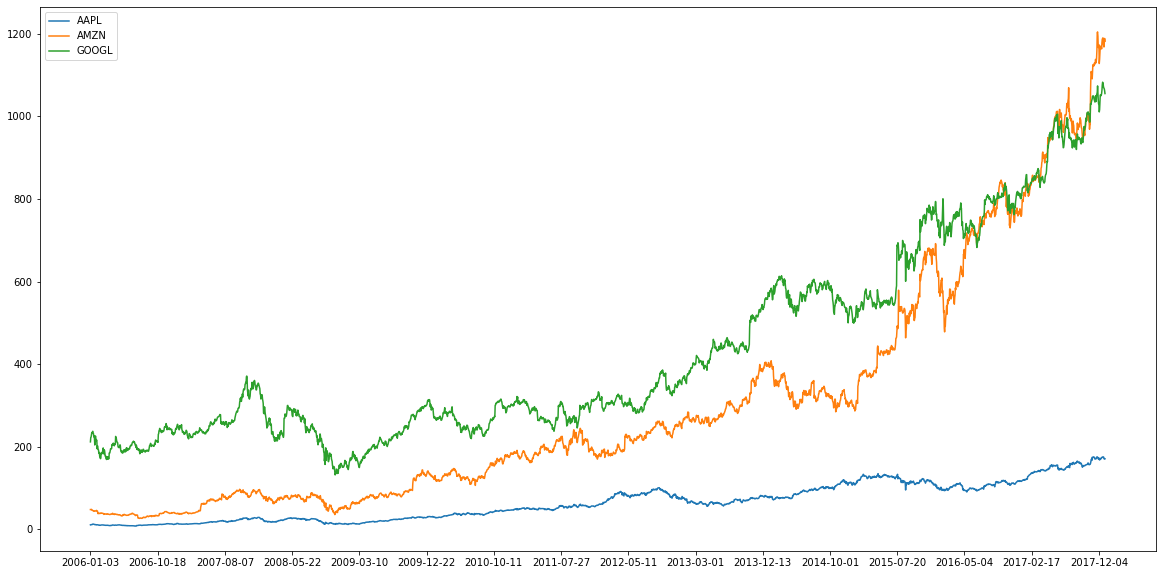

In [5]:
plt.figure(figsize=(20,10))
plt.plot(data['Date'].astype('str'),data['AAPL'], label='AAPL')
plt.plot(data['Date'].astype('str'),data['AMZN'], label='AMZN')
plt.plot(data['Date'].astype('str'),data['GOOGL'], label='GOOGL')
plt.legend()
plt.xticks(range(0, 3020, 200))

plt.show()

In [6]:
data=data.set_index("Date") # 일자를 데이터 프레임의 인덱스로 설정
data=data.dropna() # 결측치 제거
columns=data.columns

## diff

전날과의 주식 변동량을 Feature로 사용

In [23]:
data_diff = pd.DataFrame(columns=columns)
data_diff['Date']=data.index
for col in columns:
    data_diff[col] = pd.DataFrame(np.diff(data[col])) # 각 주식의 각 날짜별 이전 날과의 주식 가격 차이를 data_diff 데이터 프레임에 저장

data_diff=data_diff.dropna()

In [8]:
data_diff

,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GE,...,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM,Date
0,1.53,0.39,0.01,0.74,-0.32,0.08,0.27,1.83,0.42,0.25,...,-0.14,0.32,0.50,1.14,-0.71,0.35,0.37,-0.12,2.18,2006-01-03
1,-0.29,-0.04,-0.32,-0.54,0.47,1.07,0.46,-0.40,-0.37,-0.08,...,-0.02,0.58,-0.10,0.80,0.34,-0.50,0.71,-0.24,-0.03,2006-01-04
2,1.95,0.06,0.81,0.74,-0.21,0.45,0.57,0.27,0.52,0.11,...,0.10,0.15,0.04,0.21,0.52,0.15,0.32,-0.31,0.19,2006-01-05
3,0.22,0.21,-1.42,0.18,-1.06,0.98,0.46,0.54,0.20,0.02,...,-0.07,0.28,-0.29,-0.29,0.15,-0.08,-0.21,0.20,1.04,2006-01-06
4,-0.14,-0.07,-0.14,0.76,-0.48,0.90,-0.10,-0.73,0.17,-0.13,...,0.09,-0.25,0.44,0.34,-1.45,0.07,0.41,-0.39,-0.60,2006-01-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010,0.42,0.51,-3.82,-0.66,-0.65,0.76,-0.36,1.11,-1.90,-0.17,...,-0.10,-0.45,-0.14,-0.57,0.01,-0.12,-0.30,-0.45,0.75,2017-12-21
3011,-0.48,-3.88,-3.72,-0.58,-1.72,2.08,0.03,3.46,-0.23,0.05,...,-3.09,-0.27,0.22,-1.18,-1.12,0.27,0.30,-0.71,0.53,2017-12-22
3012,-1.17,-0.70,11.55,0.33,-0.79,1.27,-0.01,0.38,-1.00,-0.06,...,1.70,-0.18,0.47,0.20,-2.91,-0.07,0.02,0.06,0.08,2017-12-26
3013,0.35,0.90,9.09,0.10,0.87,0.90,0.19,0.73,-0.07,0.01,...,0.66,0.22,0.14,0.03,0.89,0.01,0.28,1.21,0.03,2017-12-27


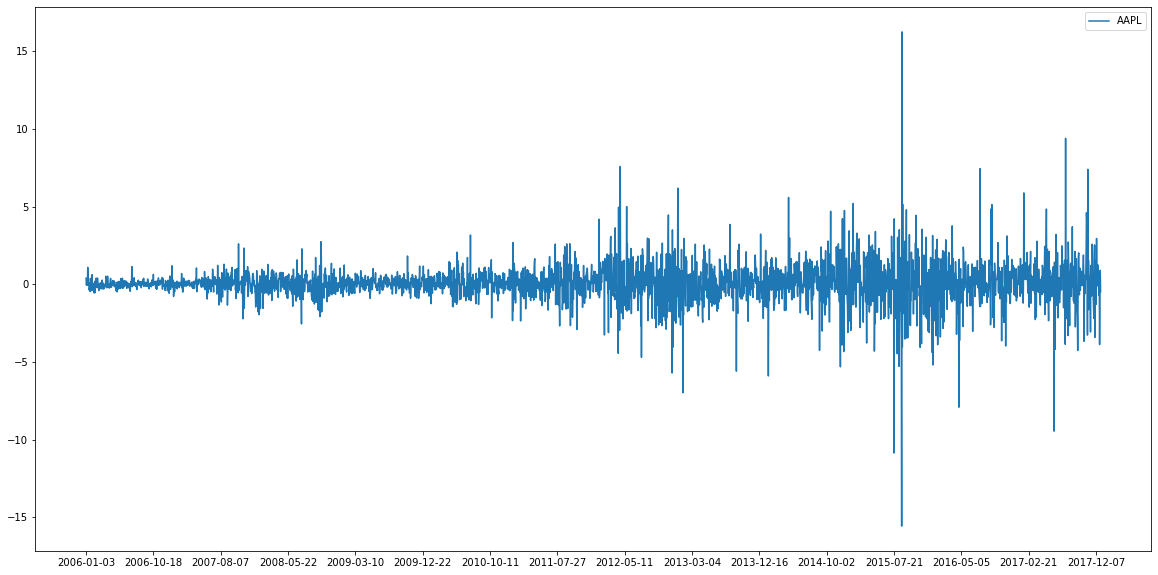

In [9]:
plt.figure(figsize=(20,10))
plt.plot(data_diff['Date'].astype('str'),data_diff['AAPL'], label='AAPL')
plt.legend()
plt.xticks(range(0, 3020, 200))

plt.show()

## Random forest

### lags 
시점 별로 앞 -5일까지의 값을 Feature로 사용

In [10]:
lags = pd.DataFrame()
for i in range(5,0,-1):
    lags['t-'+str(i)] = data_diff["AAPL"].shift(i) # -i일의 값을 칼럼을 만들어 저장하기
    lags['t'] = data_diff['AAPL'].values
lags = lags[5:]

In [11]:
lags

,t-5,t,t-4,t-3,t-2,t-1
5,0.39,1.09,-0.04,0.06,0.21,-0.07
6,-0.04,0.16,0.06,0.21,-0.07,1.09
7,0.06,0.00,0.21,-0.07,1.09,0.16
8,0.21,0.10,-0.07,1.09,0.16,0.00
9,-0.07,-0.37,1.09,0.16,0.00,0.10
...,...,...,...,...,...,...
3010,1.23,0.51,1.25,0.11,-0.12,-0.70
3011,1.25,-3.88,0.11,-0.12,-0.70,0.51
3012,0.11,-0.70,-0.12,-0.70,0.51,-3.88
3013,-0.12,0.90,-0.70,0.51,-3.88,-0.70


### Rolling mean

예측률을 높이기 위해 앞선 80일의 평균을 Feature로 사용

In [12]:
columns=data.columns
data_mean=pd.DataFrame(columns=columns)
for col in columns:
    data_mean[col] = data[col].rolling(window = 80).mean() # 앞 80일의 평균을 현재 값으로 사용
data_mean = data_mean.dropna()

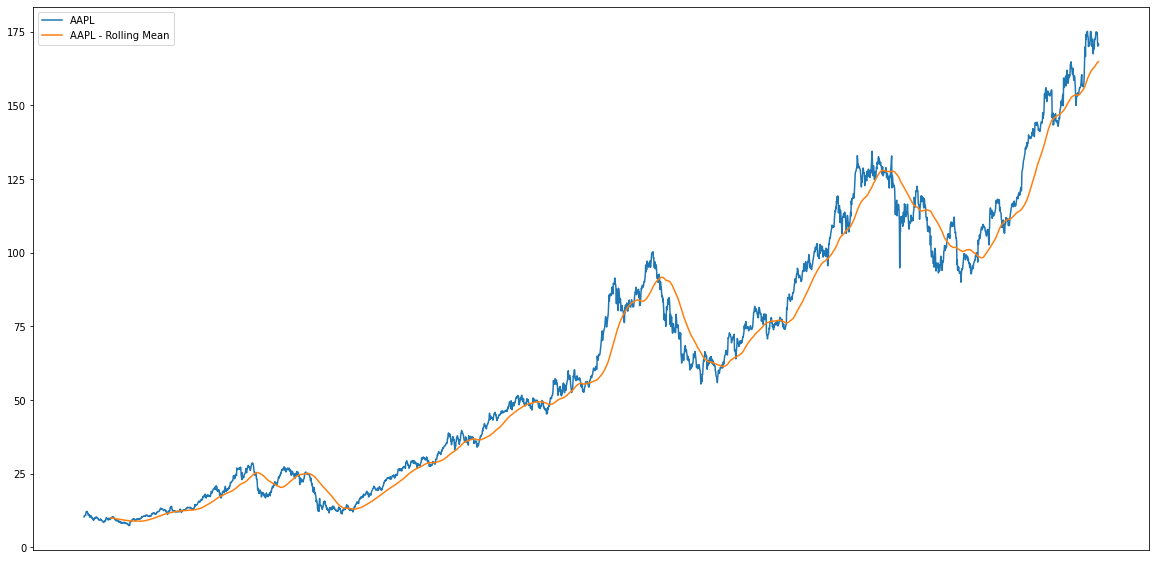

In [13]:
plt.figure(figsize=(20,10))
plt.plot(data.index,data['AAPL'], label='AAPL')
plt.plot(data_mean.index,data_mean['AAPL'], label='AAPL - Rolling Mean')
plt.plot()
plt.legend()
plt.xticks([])

plt.show()

### Modeling random forest

In [14]:
# 데이터 전처리
# 앞서 만든 Feature들을 합치기

df_forecasting=pd.DataFrame(data["AAPL"])
df_forecasting["AAPL_diff"] = df_forecasting["AAPL"].diff()
for i in range(5,0,-1):
    df_forecasting['t-'+str(i)] = df_forecasting["AAPL"].shift(i)
df_forecasting=df_forecasting.dropna()
df_forecasting["AAPL_rolling"] = df_forecasting["AAPL"].rolling(window = 80).mean()
df_forecasting= df_forecasting.dropna()

In [15]:
# 모델링

x=df_forecasting.iloc[:,1:]
y=df_forecasting.iloc[:,0]
x_train, x_valid = x.loc[x.index < '2017-10-01'], x.loc[x.index >= '2017-10-01'] 
y_train, y_valid = y.loc[y.index < '2017-10-01'], y.loc[y.index >= '2017-10-01'] # 2017년 10월 1일을 기준으로 앞 데이터를 학습 데이터, 뒤 데이터를 검증 데이터로 사용
mdl = RandomForestRegressor(n_estimators=100) # 모델 정의
mdl.fit(x_train, y_train) # 모델 학습
pred=mdl.predict(x_valid) # 검증 데이터를 활용하여 예측
pred=pd.Series(pred, index=y_valid.index)

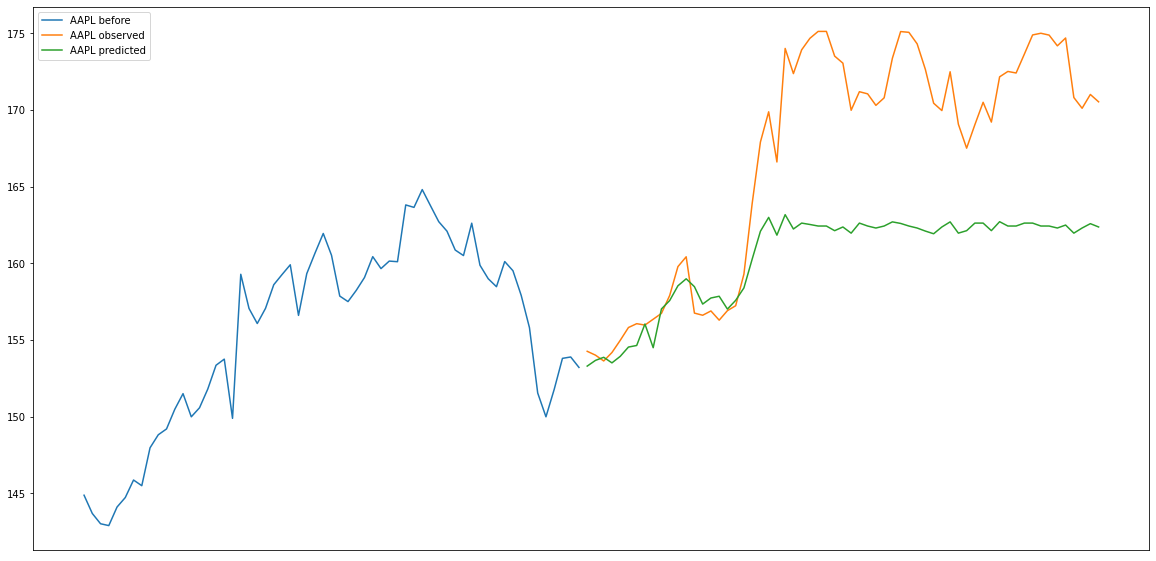

In [16]:
plt.figure(figsize=(20,10))
plt.plot(y_train.loc[y_train.index > '2017-07-01'], label='AAPL before')
plt.plot(y_valid.index, y_valid.values, label='AAPL observed')
plt.plot(pred.index, pred.values, label='AAPL predicted')
plt.plot()
plt.legend()
plt.xticks([])

plt.show()

### 각각의 주식에 대한 Random Forest 학습하기

In [17]:
# from sklearn.metrics import mean_absolute_error
score = []
predict=pd.DataFrame()
for c in data.columns: # 각 column(주식)에 대해서
    
    #pre-processing data
    df_forecasting = pd.DataFrame(data[c])
    df_forecasting["var_diff"] = df_forecasting[c].diff() # 전날과의 변동량
    for i in range(5,0,-1): 
        df_forecasting['t-'+str(i)] = df_forecasting[c].shift(i) # 이전 5일의 주식 가격
    df_forecasting=df_forecasting.dropna()
    df_forecasting["var_rolling"] = df_forecasting[c].rolling(window = 80).mean() # 이전 80일의 평균
    df_forecasting= df_forecasting.dropna()
    
    #modeling 
    x=df_forecasting.iloc[:,1:]
    y=df_forecasting.iloc[:,0]
    x_train, x_valid = x.loc[x.index < '2017-10-01'], x.loc[x.index >= '2017-10-01']
    y_train, y_valid = y.loc[y.index < '2017-10-01'], y.loc[y.index >= '2017-10-01'] # 2017년 10월 1일을 기준으로 앞 데이터를 학습 데이터, 뒤 데이터를 검증 데이터로 사용
    mdl = RandomForestRegressor(n_estimators=100) # 모델 정의
    mdl.fit(x_train, y_train) # 모델 학습
    pred=mdl.predict(x_valid) # 검증 데이터를 활용하여 예측
    predict[c+"_valid"]=y_valid.values 
    predict[c+"_predict"]=pred # 20개의 주식의 예측값과 실제값을 하나의 데이터 프레임으로 합치기
    s=mdl.score(x_valid, y_valid) # 정확도 계산
    score.append([c, s])

predict=predict.set_index(y_valid.index)
pred=pd.Series(pred, index=y_valid.index)
score=pd.DataFrame(score, columns=["Asset", "Score"])
score=score.set_index("Asset")

In [18]:
predict

,AABA_valid,AABA_predict,AAPL_valid,AAPL_predict,AMZN_valid,AMZN_predict,AXP_valid,AXP_predict,BA_valid,BA_predict,...,UNH_valid,UNH_predict,UTX_valid,UTX_predict,VZ_valid,VZ_predict,WMT_valid,WMT_predict,XOM_valid,XOM_predict
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-02,66.60,66.0612,154.26,153.2766,964.00,963.8613,90.04,89.8797,253.85,255.0709,...,195.82,194.8682,115.32,115.2356,49.30,49.3276,78.85,78.8573,81.94,81.8259
2017-10-03,67.19,66.6027,154.01,153.4966,958.00,963.4294,90.44,90.3070,254.65,255.0770,...,196.59,195.1019,116.14,116.0562,49.39,49.3927,77.90,78.0510,81.30,81.2633
2017-10-04,67.79,66.8005,153.63,153.6333,954.21,953.3747,90.59,90.6620,255.99,255.3709,...,197.50,197.1711,118.00,117.8622,49.45,49.4755,78.83,78.7303,81.41,81.4004
2017-10-05,67.75,66.6779,154.18,153.5296,970.00,960.8602,91.60,91.3824,256.12,255.5665,...,199.03,197.6578,117.87,117.7543,49.64,49.6140,79.27,79.4900,81.80,81.7967
2017-10-06,67.49,66.5250,154.97,153.7758,975.64,974.6411,90.96,90.9043,255.28,255.3542,...,199.93,197.6834,117.63,117.5443,49.96,49.9072,79.17,79.1640,81.72,81.7613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,71.42,66.3747,174.68,162.6143,1172.08,1036.6312,99.05,94.2604,298.05,254.8839,...,223.12,197.4078,127.25,122.9958,52.81,52.7598,99.00,88.0379,83.35,83.4200
2017-12-26,70.94,66.1101,170.80,162.0489,1168.36,1036.6312,98.47,94.5465,296.33,254.8534,...,222.00,197.3517,127.52,123.0684,53.11,53.2167,98.29,88.0264,83.88,83.8078
2017-12-27,69.77,65.8222,170.10,162.4409,1179.91,1049.9195,98.80,94.9628,295.54,254.8839,...,219.09,196.2916,127.45,122.9999,53.13,52.9419,98.35,88.1503,83.96,83.9133


In [19]:
score.sort_values(by='Score', ascending=False) # 예측 정확도가 높은 순으로 정렬

,Score
Asset,
VZ,0.996569
XOM,0.995187
NKE,0.993987
GE,0.992221
MRK,0.982539
PG,0.980588
DIS,0.978190
CVX,0.974656
IBM,0.929473


In [20]:
print("Max is:", score[score["Score"]==score.max()[0]].index) # 가장 예측 정확도가 높은 주식
print("Min is:", score[score["Score"]==score.min()[0]].index) # 가장 예측 정확도가 낮은 주식

Max is: Index(['VZ'], dtype='object', name='Asset')
Min is: Index(['INTC'], dtype='object', name='Asset')


### the worst performance : INTC

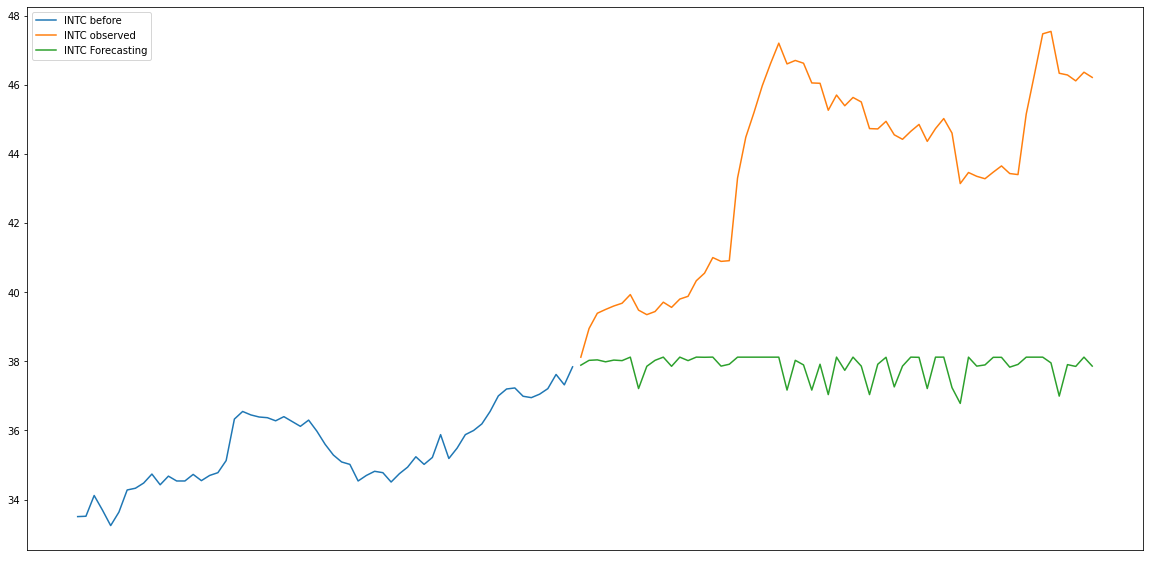

In [21]:
plt.figure(figsize=(20,10))
plt.plot(data["INTC"].loc['2017-07-01':'2017-10-01'], label='INTC before')
plt.plot(predict["INTC_valid"], label='INTC observed')
plt.plot(predict["INTC_predict"], label='INTC Forecasting')
plt.plot()
plt.legend()
plt.xticks([])

plt.show()

### the best performance : VZ

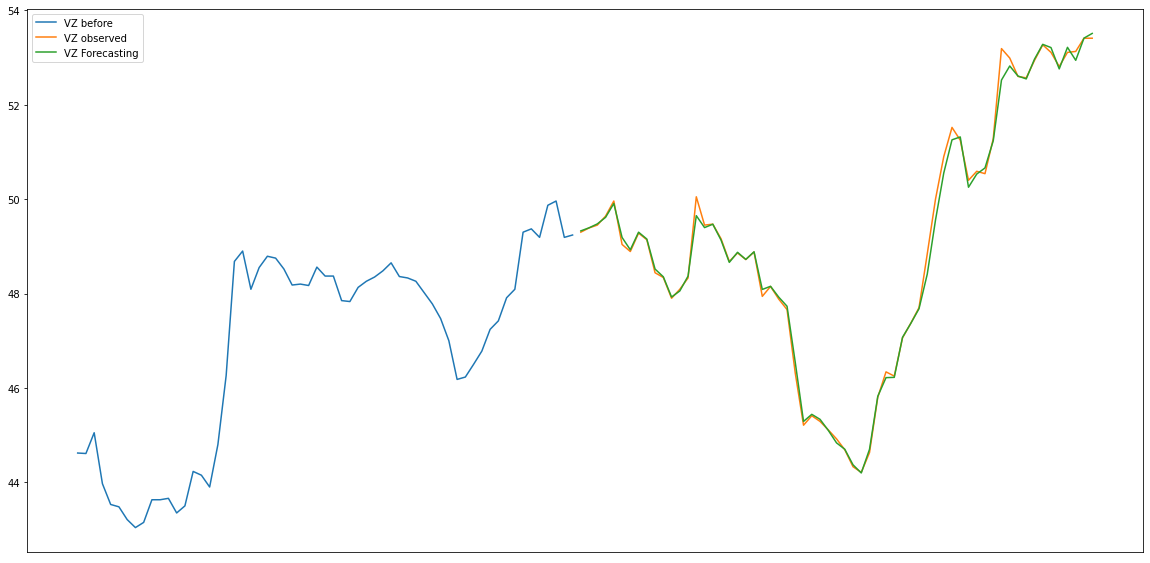

In [22]:
plt.figure(figsize=(20,10))
plt.plot(data["VZ"].loc['2017-07-01':'2017-10-01'], label='VZ before')
plt.plot(predict["VZ_valid"], label='VZ observed')
plt.plot(predict["VZ_predict"], label='VZ Forecasting')
plt.plot()
plt.legend()
plt.xticks([])

plt.show()